In [1]:
import itertools as itt
from collections import Counter

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import biomappings

In [2]:
positive_mappings = biomappings.load_mappings()
print(f"There are {len(positive_mappings):,} positive mappings")

There are 8,685 positive mappings


In [3]:
negative_mappings = biomappings.load_false_mappings()
print(f"There are {len(negative_mappings):,} negative mappings")

There are 1,185 negative mappings


In [4]:
predicted_mappings = biomappings.load_predictions()
print(f"There are {len(predicted_mappings):,} predicted mappings")

There are 40,974 predicted mappings


In [5]:
keyed_mappings = [
    ("positive", positive_mappings),
    ("negative", negative_mappings),
    ("predicted", predicted_mappings),
]

# Biased Measurement of Precision

There are two kinds of mappings we'll consider:

1. Manually curated positive (i.e., correct) mappings. These correspond to true positives.
2. Manually curated negative (i.e., incorrect) mappings. These correspond to false positives.

Most of these mappings originated as predictions from Gilda, with an additional small number being input by curators directly (which is small enough that we'll disregard).

Unfortunately, it's hard to accurately count false negatives and true negatives as the space of potential negative mappings is massive, and also can be defined in several ways, such as if you make the assumption that mappings must be one-to-one and not one-to-many, many-to-one, or many-to-many.

## Caveats

The metrics reported in this section are **biased** due to non-random ways curation was done:

1. Curation was done based on task-based need, meaning that certain resources were included and others were excluded
2. Curation was prioritized based on confidence in order to maximize positive mapping throughput with respect to curator effort

In [6]:
tp = len(positive_mappings)
fp = len(negative_mappings)

precision = tp / (tp + fp)


print(f"The overall unweighed precision is {precision:.2%}.")

The overall unweighed precision is 87.99%.


## Precision by Source

Because mappings are first predicted on the basis of source, the overall precision can be split based on the source prefix of each mapping.

In [7]:
pairs = {
    key: Counter(mapping["source prefix"] for mapping in mappings)
    for key, mappings in keyed_mappings
}
df1 = pd.DataFrame(pairs).fillna(0).astype(int)
df1.index.name = "source"
df1 = df1[df1["positive"] + df1["negative"] > 20]
df1["curated"] = df1["positive"] + df1["negative"]
df1["complete"] = (df1["curated"] / (df1["curated"] + df1["predicted"])).round(2)
df1["precision"] = (df1["positive"] / df1["curated"]).round(2)
df1.sort_values("precision", inplace=True, ascending=False)

df1

,positive,negative,predicted,curated,complete,precision
source,,,,,,
uniprot.chain,27,0,0,27,1.00,1.00
chebi,1617,13,9848,1630,0.14,0.99
uberon,131,3,68,134,0.66,0.98
mondo,207,7,78,214,0.73,0.97
mesh,4329,327,26878,4656,0.15,0.93
ccle,690,70,0,760,1.00,0.91
pr,80,9,0,89,1.00,0.90
wikipathways,467,60,1685,527,0.24,0.89
agrovoc,142,20,0,162,1.00,0.88


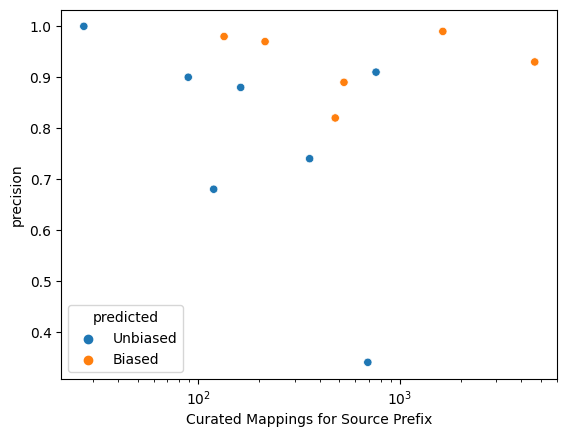

In [8]:
ax = sns.scatterplot(
    data=df1,
    x="curated",
    y="precision",
    hue=df1["predicted"].map(lambda v: "Biased" if v > 0 else "Unbiased"),
)
ax.set_xscale("log")
ax.set_xlabel("Curated Mappings for Source Prefix")

plt.show()

A more granular view is calculated by stratifying by both the source and target prefix of the mappings.

If there are no predictions (i.e., curation was done exhaustively), then we know that the false negative is zero. 
Trivially, this means that the sensitivity is 100% and F_1 is equivalent to precision. This allows calculating additional metrics besides precision that include the true positives, false positives, and false negatives, but this doesn't allow for calculating more common metrics like accuracy, MCC, etc.

In [9]:
pairs = {
    key: Counter(
        tuple(sorted((mapping["source prefix"], mapping["target prefix"]))) for mapping in mappings
    )
    for key, mappings in keyed_mappings
}
df2 = pd.DataFrame(pairs).fillna(0).astype(int)
df2.index.set_names(["source", "target"], inplace=True)
df2 = df2[df2["positive"] + df2["negative"] > 20]
df2["curated"] = df2["positive"] + df2["negative"]
df2["complete"] = (df2["curated"] / (df2["curated"] + df2["predicted"])).round(2)
df2["precision"] = (df2["positive"] / df2["curated"]).round(2)
df2.sort_values("precision", inplace=True, ascending=False)
df2

positive  negative  predicted  curated  complete  \
source       target                                                            
mesh         uniprot             378         0      10970      378      0.03   
go           wikipathways        366         0          0      366      1.00   
ncbiprotein  uniprot.chain        26         0          0       26      1.00   
kegg.pathway wikipathways         70         0          0       70      1.00   
             reactome             61         0          0       61      1.00   
chebi        mesh               2698        23      12061     2721      0.18   
reactome     wikipathways         73         1          0       74      1.00   
mesh         ncit                888        14      11751      902      0.07   
ccle         efo                 570        10          0      580      1.00   
mesh         uberon              131         3         68      134      0.66   
             mondo               207         7         78      214      0.73   
doid         efo                  63         7         72       70      0.49   
pr           uniprot.chain        81         9          0       90      1.00   
agro         agrovoc             142        20          0      162      1.00   
go           kegg.pathway        113        16          0      129      1.00   
doid         mesh               1455       198         58     1653      0.97   
             umls                187        35       2345      222      0.09   
hgnc         mesh                102        21       1368      123      0.08   
efo          mesh                108        25        166      133      0.44   
go           mesh                432       102          0      534      1.00   
             reactome            222        91          0      313      1.00   
cl           mesh                 81        38          0      119      1.00   
ccle         cellosaurus         114        59          0      173      1.00   
mesh         wikipathways         18        45          0       63      1.00   
kegg.pathway mesh                 25        77          0      102      1.00   
mesh         reactome              8       218          0      226      1.00   
fplx         reactome              0        49          0       49      1.00   
chebi        reactome              0        85          0       85      1.00   

                            precision  
source       target                    
mesh         uniprot             1.00  
go           wikipathways        1.00  
ncbiprotein  uniprot.chain       1.00  
kegg.pathway wikipathways        1.00  
             reactome            1.00  
chebi        mesh                0.99  
reactome     wikipathways        0.99  
mesh         ncit                0.98  
ccle         efo                 0.98  
mesh         uberon              0.98  
             mondo               0.97  
doid         efo                 0.90  
pr           uniprot.chain       0.90  
agro         agrovoc             0.88  
go           kegg.pathway        0.88  
doid         mesh                0.88  
             umls                0.84  
hgnc         mesh                0.83  
efo          mesh                0.81  
go           mesh                0.81  
             reactome            0.71  
cl           mesh                0.68  
ccle         cellosaurus         0.66  
mesh         wikipathways        0.29  
kegg.pathway mesh                0.25  
mesh         reactome            0.04  
fplx         reactome            0.00  
chebi        reactome            0.00

Note that the biased precisions are much higher - this is an artifact of the "easy-first" curation method, which tends towards curating correct mappings. In many cases, exact text matches make it much quicker to curate a correct match than the need to read through web pages to determine if something is correct/incorrect, and usually results in incorrect.

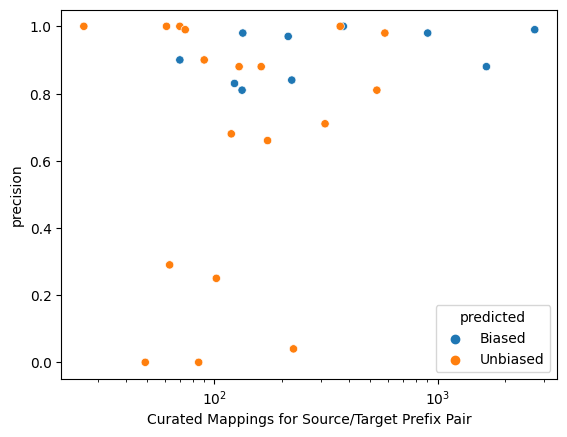

In [10]:
ax = sns.scatterplot(
    data=df2,
    x="curated",
    y="precision",
    hue=df2["predicted"].map(lambda v: "Biased" if v > 0 else "Unbiased"),
)
ax.set_xscale("log")
ax.set_xlabel("Curated Mappings for Source/Target Prefix Pair")
plt.show()

# Remaining Curation Effort

There are a few more low-hanging fruit for exhaustive curation. Additionally, there are some that we don't need to curate like mesh-uniprot that are high-confidence predictions.

In [11]:
df2[df2["predicted"] > 0].reset_index()[["source", "target", "predicted", "complete"]].sort_values(
    "predicted"
)

,source,target,predicted,complete
6,doid,mesh,58,0.97
3,mesh,uberon,68,0.66
5,doid,efo,72,0.49
4,mesh,mondo,78,0.73
9,efo,mesh,166,0.44
8,hgnc,mesh,1368,0.08
7,doid,umls,2345,0.09
0,mesh,uniprot,10970,0.03
2,mesh,ncit,11751,0.07
1,chebi,mesh,12061,0.18
